# News-based Return Prediction

## Setup

### Imports

In [1]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pyro
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from src.utils.embeddings import FinBertEmbedder
from src.utils.news import create_lagged_news_sequences
from src.modules.bayesian.lstm import BayesianLSTM
import matplotlib.pyplot as plt

### Constants

In [2]:
symbol = "TSLA"
lag = 5
predict_days = 5

## Dataset

### Loading

In [3]:
df = pd.read_csv(f'data/data_{symbol}.csv')

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df['2024-04-01':]

df = df[['text', 'return']]
df['text'] = df['text'].fillna('No news.')

### Feature Preparation

In [4]:
embedder = FinBertEmbedder()
embeddings = embedder.embed(df['text'].tolist())

In [5]:
X_lagged = create_lagged_news_sequences(embeddings, lag)

X_train, X_test = X_lagged[:-lag], X_lagged[-lag:]

### Target Preparation

In [6]:
scaler = StandardScaler()
targets = scaler.fit_transform(df[['return']].values)

y_train = torch.tensor(targets[lag:-predict_days], dtype=torch.float32).squeeze(-1)
y_test = torch.tensor(targets[-predict_days:], dtype=torch.float32).squeeze(-1)

## Model Training

### Pipeline

In [7]:
pyro.set_rng_seed(42)
pyro.clear_param_store()

model = BayesianLSTM("model1", input_size=768, hidden_size=16, output_size=1)

optimizer = Adam({"lr": 1e-3})
guide = AutoDiagonalNormal(model)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

loss_log = []

for step in range(5000):
    loss = svi.step(X_train, y_train)
    loss_log.append(loss)
    if step % 100 == 0:
        print(f"[Step {step}] Loss: {loss:.4f}")


[Step 0] Loss: 93714.9394
[Step 100] Loss: 87947.7415
[Step 200] Loss: 82887.3445
[Step 300] Loss: 78164.6050
[Step 400] Loss: 73368.0310
[Step 500] Loss: 68622.8150
[Step 600] Loss: 64262.3947
[Step 700] Loss: 59877.8500
[Step 800] Loss: 55328.1196
[Step 900] Loss: 51337.7057
[Step 1000] Loss: 47404.2215
[Step 1100] Loss: 43256.3654
[Step 1200] Loss: 39595.4420
[Step 1300] Loss: 36126.6152
[Step 1400] Loss: 32867.4858
[Step 1500] Loss: 29376.3988
[Step 1600] Loss: 26422.6009
[Step 1700] Loss: 23672.1517
[Step 1800] Loss: 20910.2912
[Step 1900] Loss: 18008.7726
[Step 2000] Loss: 15933.5692
[Step 2100] Loss: 13793.1850
[Step 2200] Loss: 11949.9644
[Step 2300] Loss: 10089.2630
[Step 2400] Loss: 8542.0595
[Step 2500] Loss: 7387.7156
[Step 2600] Loss: 6160.8764
[Step 2700] Loss: 5209.2166
[Step 2800] Loss: 4362.4932
[Step 2900] Loss: 3695.4378
[Step 3000] Loss: 3075.1528
[Step 3100] Loss: 2582.8857
[Step 3200] Loss: 2183.8158
[Step 3300] Loss: 1726.1206
[Step 3400] Loss: 1523.6925
[Step 35

### Loss Visualization

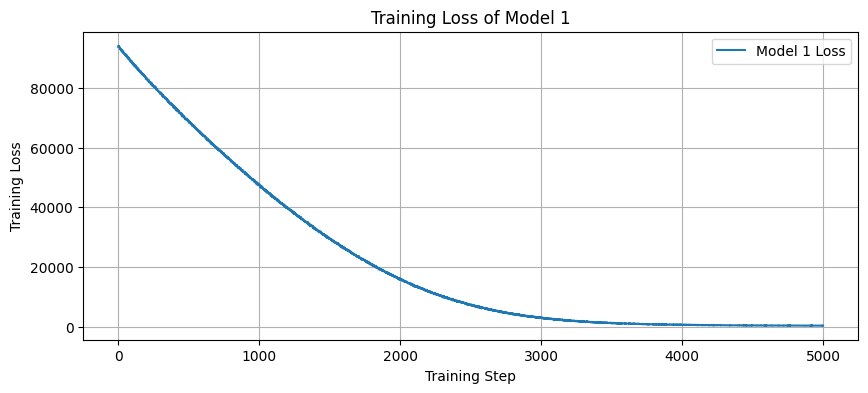

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(loss_log, label='Model 1 Loss')
plt.title("Training Loss of Model 1")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

## Model Testing

### Pipeline

In [9]:
predictive = Predictive(model, guide=guide, num_samples=500)
samples = predictive(X_test)

posterior_preds = samples["model1_obs"]

mean = samples["model1_obs"].mean(0).detach().numpy()
std = samples["model1_obs"].std(0).detach().numpy()

mean_rescaled = scaler.inverse_transform(mean.reshape(-1, 1)).flatten()
std_rescaled = std * scaler.scale_[0]

### Prediction Visualization

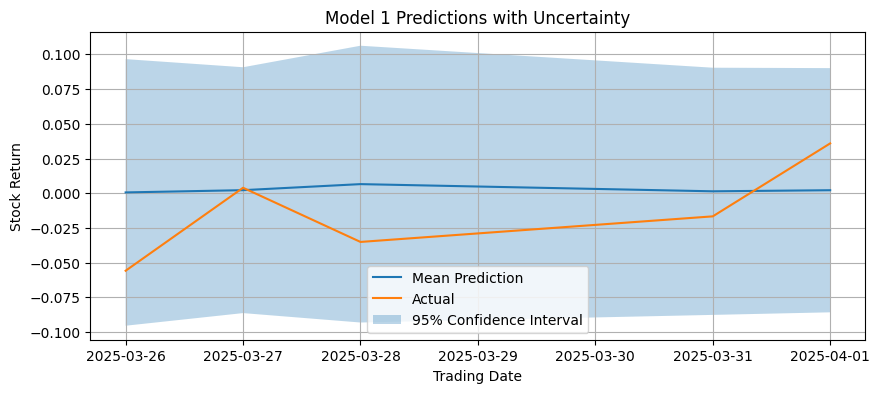

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(df['return'][-predict_days:].index, mean_rescaled, label='Mean Prediction')
plt.plot(df['return'][-predict_days:].index, df['return'][-predict_days:], label='Actual')
plt.fill_between(
    df['return'][-predict_days:].index,
    mean_rescaled - 2 * std_rescaled,
    mean_rescaled + 2 * std_rescaled,
    alpha=0.3, label='95% Confidence Interval'
)
plt.title('Model 1 Predictions with Uncertainty')
plt.ylabel("Stock Return")
plt.xlabel("Trading Date")
plt.grid(True)
plt.legend()
plt.show()